# `GemPy` $\Rightarrow$ `discretize` $\Rightarrow$ `SimPEG`

A first test at creating a model with [GemPy](https://gempy.org), populating it with conductivities, move it into [discretize](http://discretize.simpeg.xyz), and calculate MT data with [SimPEG](https://simpeg.xyz). Having it in discretize allows us to plot it in VTK directly in the notebook using [PyVista](https://github.com/pyvista)

For this, we use the Perth basin example, [perth_basin.ipynb](https://github.com/cgre-aachen/gempy/blob/master/notebooks/examples/perth_basin.ipynb), from the `GemPy` website, and combine it with the [plot_foward_MTTipper3D.ipynb](http://docs.simpeg.xyz/content/examples/08-nsem/plot_foward_MTTipper3D.html#sphx-glr-content-examples-08-nsem-plot-foward-mttipper3d-py) from the `SimPEG` examples.

In [1]:
import panel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import vista
import discretize
import gempy as gp
import SimPEG as simpeg
from SimPEG.EM import NSEM
from pymatsolver import Pardiso as Solver

## Creating a geological model

In [2]:
# Initiate a model
geo_model = gp.create_model('gempy-discretize-simpeg')

nx, ny, nz = 50, 50, 100

# Importing the data from CSV-files and setting extent and resolution
gp.init_data(
    geo_model,
    extent = [337000, 400000, 6640000, 6710000, -18000, 1000],
    resolution = [nx, ny, nz],
    path_i = "./data/Paper_GU2F_sc_faults_topo_Points.csv", 
    path_o = "./data/Paper_GU2F_sc_faults_topo_Foliations.csv"
)

gempy-discretize-simpeg  2019-05-10 15:45

We run the plot settings here. For an issue with `init_data`, that would create a big white empty space if we set `%matplotlib notebook` before.

TODO: Create an issue.

In [3]:
%matplotlib notebook
plt.style.use('ggplot')

## Initiate the stratigraphies and faults, and add conductivities to lithology

In [4]:
# We just follow the example here
del_surfaces = ['Cadda', 'Woodada_Kockatea', 'Cattamarra']
geo_model.delete_surfaces(del_surfaces)

# Map the different series
gp.map_series_to_surfaces(
    geo_model, 
    {
        "fault_Abrolhos_Transfer": ["Abrolhos_Transfer"],
        "fault_Coomallo": ["Coomallo"],
        "fault_Eneabba_South": ["Eneabba_South"],
        "fault_Hypo_fault_W": ["Hypo_fault_W"],
        "fault_Hypo_fault_E": ["Hypo_fault_E"],
        "fault_Urella_North": ["Urella_North"],
        "fault_Urella_South": ["Urella_South"],
        "fault_Darling": ["Darling"],
        "Sedimentary_Series": ['Cretaceous', 'Yarragadee', 'Eneabba', 'Lesueur', 'Permian']
    }
)

surface                   series  order_surfaces  isBasement    color vertices edges  id
15  Abrolhos_Transfer  fault_Abrolhos_Transfer               1       False  #d4ffff      NaN   NaN   1
11           Coomallo           fault_Coomallo               1       False  #a8ff04      NaN   NaN   2
10      Eneabba_South      fault_Eneabba_South               1       False  #b2996e      NaN   NaN   3
13       Hypo_fault_W       fault_Hypo_fault_W               1       False  #894585      NaN   NaN   4
12       Hypo_fault_E       fault_Hypo_fault_E               1       False  #69d84f      NaN   NaN   5
9        Urella_North       fault_Urella_North               1       False  #56ae57      NaN   NaN   6
14       Urella_South       fault_Urella_South               1       False  #70b23f      NaN   NaN   7
8             Darling            fault_Darling               1       False  #acc2d9      NaN   NaN   8
0             Lesueur       Sedimentary_Series               1       False  #015482      NaN   NaN   9
1             Permian       Sedimentary_Series               2       False  #9f0052      NaN   NaN  10
3          Yarragadee       Sedimentary_Series               3       False  #728f02      NaN   NaN  11
4             Eneabba       Sedimentary_Series               4       False  #443988      NaN   NaN  12
7          Cretaceous       Sedimentary_Series               5       False  #5DA629      NaN   NaN  13
16           basement                 Basement               1        True  #65ab7c      NaN   NaN  14

In [5]:
order_series = ["fault_Abrolhos_Transfer",
                "fault_Coomallo",
                "fault_Eneabba_South",
                "fault_Hypo_fault_W",
                "fault_Hypo_fault_E",
                "fault_Urella_North",
                "fault_Darling",
                "fault_Urella_South",
                "Sedimentary_Series",
                "Basement"]

geo_model.reorder_series(order_series)

order_series BottomRelation
fault_Abrolhos_Transfer             1        Erosion
fault_Coomallo                      2        Erosion
fault_Eneabba_South                 3        Erosion
fault_Hypo_fault_W                  4        Erosion
fault_Hypo_fault_E                  5        Erosion
fault_Urella_North                  6        Erosion
fault_Darling                       7        Erosion
fault_Urella_South                  8        Erosion
Sedimentary_Series                  9        Erosion
Basement                           10        Erosion

In [6]:
# Drop input data from the deleted series:
geo_model.surface_points.df.dropna(inplace=True)
geo_model.orientations.df.dropna(inplace=True)

In [7]:
geo_model.set_is_fault(["fault_Abrolhos_Transfer",
                        "fault_Coomallo",
                        "fault_Eneabba_South",
                        "fault_Hypo_fault_W",
                        "fault_Hypo_fault_E",
                        "fault_Urella_North",
                        "fault_Darling",
                        "fault_Urella_South"])

Fault colors changed. If you do not like this behavior, set change_color to False.


isFault  isFinite
fault_Abrolhos_Transfer     True     False
fault_Coomallo              True     False
fault_Eneabba_South         True     False
fault_Hypo_fault_W          True     False
fault_Hypo_fault_E          True     False
fault_Urella_North          True     False
fault_Darling               True     False
fault_Urella_South          True     False
Sedimentary_Series         False     False
Basement                   False     False

In [8]:
fr = geo_model.faults.faults_relations_df.values
fr[:, :-2] = False
geo_model.set_fault_relation(fr)

fault_Abrolhos_Transfer  fault_Coomallo  \
fault_Abrolhos_Transfer                    False           False   
fault_Coomallo                             False           False   
fault_Eneabba_South                        False           False   
fault_Hypo_fault_W                         False           False   
fault_Hypo_fault_E                         False           False   
fault_Urella_North                         False           False   
fault_Darling                              False           False   
fault_Urella_South                         False           False   
Sedimentary_Series                         False           False   
Basement                                   False           False   

                         fault_Eneabba_South  fault_Hypo_fault_W  \
fault_Abrolhos_Transfer                False               False   
fault_Coomallo                         False               False   
fault_Eneabba_South                    False               False   
fault_Hypo_fault_W                     False               False   
fault_Hypo_fault_E                     False               False   
fault_Urella_North                     False               False   
fault_Darling                          False               False   
fault_Urella_South                     False               False   
Sedimentary_Series                     False               False   
Basement                               False               False   

                         fault_Hypo_fault_E  fault_Urella_North  \
fault_Abrolhos_Transfer               False               False   
fault_Coomallo                        False               False   
fault_Eneabba_South                   False               False   
fault_Hypo_fault_W                    False               False   
fault_Hypo_fault_E                    False               False   
fault_Urella_North                    False               False   
fault_Darling                         False               False   
fault_Urella_South                    False               False   
Sedimentary_Series                    False               False   
Basement                              False               False   

                         fault_Darling  fault_Urella_South  \
fault_Abrolhos_Transfer          False               False   
fault_Coomallo                   False               False   
fault_Eneabba_South              False               False   
fault_Hypo_fault_W               False               False   
fault_Hypo_fault_E               False               False   
fault_Urella_North               False               False   
fault_Darling                    False               False   
fault_Urella_South               False               False   
Sedimentary_Series               False               False   
Basement                         False               False   

                         Sedimentary_Series  Basement  
fault_Abrolhos_Transfer                True      True  
fault_Coomallo                         True      True  
fault_Eneabba_South                    True      True  
fault_Hypo_fault_W                     True      True  
fault_Hypo_fault_E                     True      True  
fault_Urella_North                     True      True  
fault_Darling                          True      True  
fault_Urella_South                     True      True  
Sedimentary_Series                    False     False  
Basement                              False     False

## Create model

In [9]:
interp_data = gp.set_interpolation_data(geo_model,  
                                        compile_theano=True,
                                        theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!


In [10]:
gp.compute_model(geo_model)


Lithology ids 
  [14.         14.         14.         ... 14.         14.
 13.00000333] 

<IPython.core.display.Javascript object>


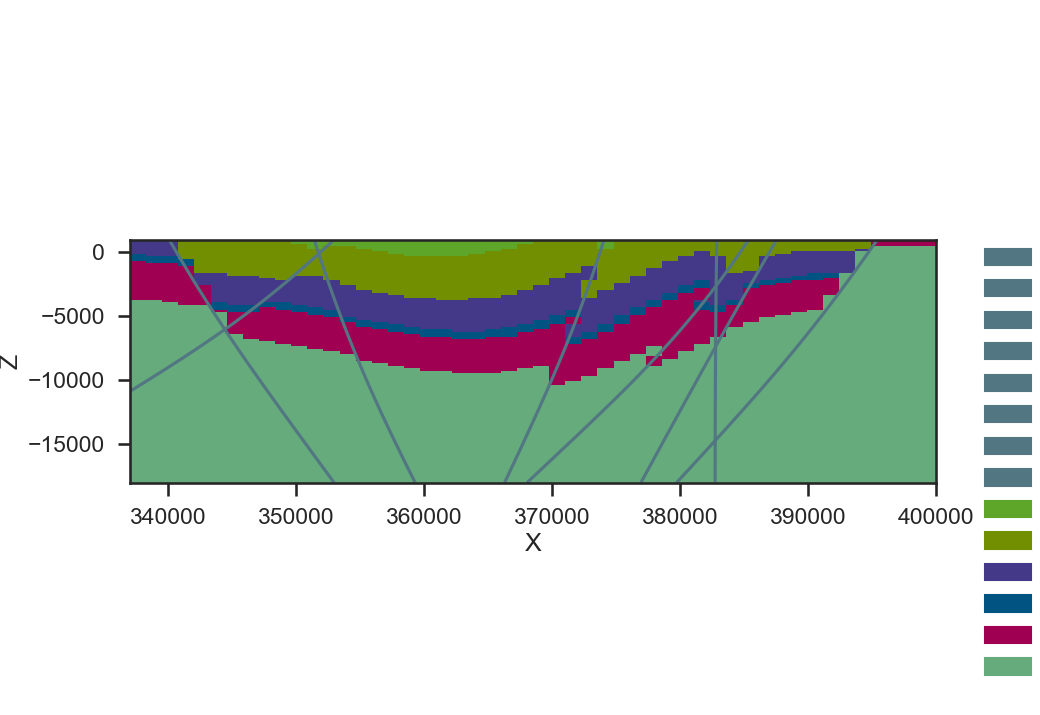

In [11]:
gp.plot.plot_section(geo_model, 25)
plt.show()

## Show the model in discretize

In [12]:
xminmax = np.min(geo_model.grid.values[:, 0]), np.max(geo_model.grid.values[:, 0])
yminmax = np.min(geo_model.grid.values[:, 1]), np.max(geo_model.grid.values[:, 1])
zminmax = np.min(geo_model.grid.values[:, 2]), np.max(geo_model.grid.values[:, 2])

xminmax, yminmax, zminmax

((337630.0, 399370.0), (6640700.0, 6709300.0), (-17810.0, 810.0))

In [13]:
dx = np.diff(xminmax)/nx
dy = np.diff(yminmax)/ny
dz = np.diff(zminmax)/nz

dx, dy, dz

(array([1234.8]), array([1372.]), array([186.2]))

In [14]:
# Make a mesh
grid = simpeg.Mesh.TensorMesh(
    [
        [(dx, nx)],
        [(dy, ny)],
        [(dz, nz)]
    ],
    x0=['C', 'C', zminmax[0]]
)
grid.x0 += [np.mean(xminmax), np.mean(yminmax), 0]
grid

TensorMesh: 250,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     50    337,630.00    399,370.00  1,234.80  1,234.80    1.00
   y     50  6,640,700.00  6,709,300.00  1,372.00  1,372.00    1.00
   z    100    -17,810.00        810.00    186.20    186.20    1.00

<IPython.core.display.Javascript object>


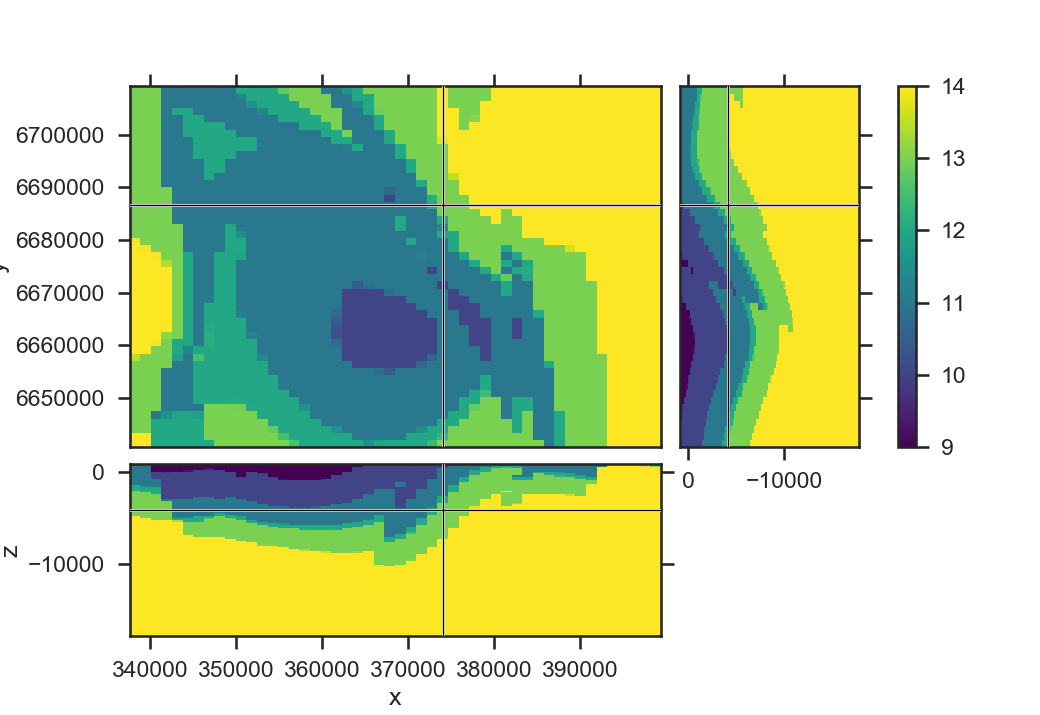

In [15]:
vals = geo_model.solutions.lith_block.reshape(grid.vnC, order='C').ravel('F')
grid.plot_3d_slicer(vals, pcolorOpts={'cmap': 'viridis'})

In [16]:
dataset = grid.toVTK({'vals': vals})

# Create the rendering scene and add a grid axes
p = vista.Plotter(notebook=True)
p.show_grid(location='outer')

dparams = {'cmap': 'viridis', 'show_edges': False}
# Add spatially referenced data to the scene

p.add_mesh(dataset.slice('x'), name='x-slice', **dparams)
p.add_mesh(dataset.slice('y'), name='y-slice', **dparams)
#p.add_mesh(dataset.slice('z'), name='z-slice', **dparams)

# Add a layer as 3D
p.add_mesh(dataset.threshold([11.5, 12.5]),  name='vol', **dparams)

# Show the scene!
p.show(use_panel=True)

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

## Create discretize mesh

In [17]:
# Make a mesh
grid = simpeg.Mesh.TensorMesh(
    [
        [(100, 9, -1.5), (100., 13), (100, 9, 1.5)],
        [(100, 9, -1.5), (100., 13), (100, 9, 1.5)],
        [(80, 9, -1.5), (89., 10), (80, 6, 2)]
    ],
    x0='CCC'
)
grid.x0 += [np.mean(xminmax), np.mean(yminmax), -3000]
grid

TensorMesh: 24,025 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     31    356,616.99    380,383.01    100.00  3,844.34    1.50
   y     31  6,663,116.99  6,686,883.01    100.00  3,844.34    1.50
   z     25    -12,978.20      6,978.20     89.00  5,120.00    2.00

## Put conductivities to stratigraphic units

We could define the conductivities before, but currently it is difficult for GemPy to interpolate for something like conductivities with a very wide range of values (several orders of magnitudes). So we can simply map it here to the `id` (GemPy does no interpolation).

In [18]:
# First, we have to get the id's for our mesh
sol = gp.compute_model_at(grid.gridCC, geo_model)

In [19]:
geo_model.surfaces

surface                   series  order_surfaces  isBasement    color                                           vertices                                              edges  id
15  Abrolhos_Transfer  fault_Abrolhos_Transfer               1       False  #527682  [[338218.04637789726, 6708600.0, -18000.0], [3...  [[2, 1, 0], [2, 0, 3], [5, 4, 1], [5, 1, 2], [...   1
11           Coomallo           fault_Coomallo               1       False  #527682  [[338259.76853609085, 6640000.0, -2990.0], [33...  [[2, 1, 0], [4, 3, 2], [0, 4, 2], [5, 4, 0], [...   2
10      Eneabba_South      fault_Eneabba_South               1       False  #527682  [[337000.0, 6640000.0, -9148.451538085938], [3...  [[2, 1, 0], [1, 2, 3], [2, 4, 3], [2, 5, 4], [...   3
13       Hypo_fault_W       fault_Hypo_fault_W               1       False  #527682  [[343290.4013824463, 6705800.0, 240.0], [34330...  [[2, 1, 0], [4, 3, 0], [4, 0, 1], [6, 5, 3], [...   4
12       Hypo_fault_E       fault_Hypo_fault_E               1       False  #527682  [[354175.8212852478, 6708600.0, -18000.0], [35...  [[2, 1, 0], [2, 0, 3], [5, 4, 1], [5, 1, 2], [...   5
9        Urella_North       fault_Urella_North               1       False  #527682  [[360940.0, 6705584.23538208, -18000.0], [3608...  [[2, 1, 0], [1, 2, 3], [4, 1, 3], [5, 1, 4], [...   6
8             Darling            fault_Darling               1       False  #527682  [[376060.0, 6691282.466125488, -18000.0], [375...  [[2, 1, 0], [1, 2, 3], [4, 1, 3], [5, 1, 4], [...   7
14       Urella_South       fault_Urella_South               1       False  #527682  [[372142.4710845947, 6708600.0, -18000.0], [37...  [[2, 1, 0], [2, 0, 3], [4, 1, 2], [7, 6, 5], [...   8
7          Cretaceous       Sedimentary_Series               1       False  #5DA629  [[337000.0, 6640000.0, 402.4854278564453], [33...  [[2, 1, 0], [3, 1, 2], [6, 5, 4], [3, 6, 4], [...   9
3          Yarragadee       Sedimentary_Series               2       False  #728f02  [[338188.7862455845, 6641400.0, -1850.0], [338...  [[2, 1, 0], [0, 1, 3], [2, 5, 4], [2, 0, 5], [...  10
4             Eneabba       Sedimentary_Series               3       False  #443988  [[337943.36368083954, 6641400.0, -2800.0], [33...  [[2, 1, 0], [0, 1, 3], [2, 5, 4], [2, 0, 5], [...  11
0             Lesueur       Sedimentary_Series               4       False  #015482  [[337671.134185791, 6641400.0, -2800.0], [3382...  [[2, 1, 0], [0, 1, 3], [2, 5, 4], [2, 0, 5], [...  12
1             Permian       Sedimentary_Series               5       False  #9f0052  [[337000.0, 6640034.394160658, -3940.0], [3382...  [[2, 1, 0], [1, 3, 0], [1, 4, 3], [2, 0, 5], [...  13
16           basement                 Basement               1        True  #65ab7c                                                NaN                                                NaN  14

In [27]:
# Now, we convert the id's to conductivities

# I have no ideas what conductivities have these units. Just putting in some numbers...

cond = sol[0][0, :grid.nC]
cond[np.round(cond) == 9] = 0.1   # Cretaceous
cond[np.round(cond) == 10] = 0.5  # Yarragadee
cond[np.round(cond) == 11] = 10  # Eneabba
cond[np.round(cond) == 12] = 1  # Lesueur
cond[np.round(cond) == 13] = 0.1  # Permian  
cond[np.round(cond) == 14] = 0.05  # Basement 

cond[grid.gridCC[:, 2] >= 1000] = 1e-8  # Air

# Background
condBG = sol[0][0, :grid.nC]
condBG[grid.gridCC[:, 2] >= 1000] = 1e-8  # Air
condBG[grid.gridCC[:, 2] < 1000] = 0.1

## Plot the input model

<IPython.core.display.Javascript object>


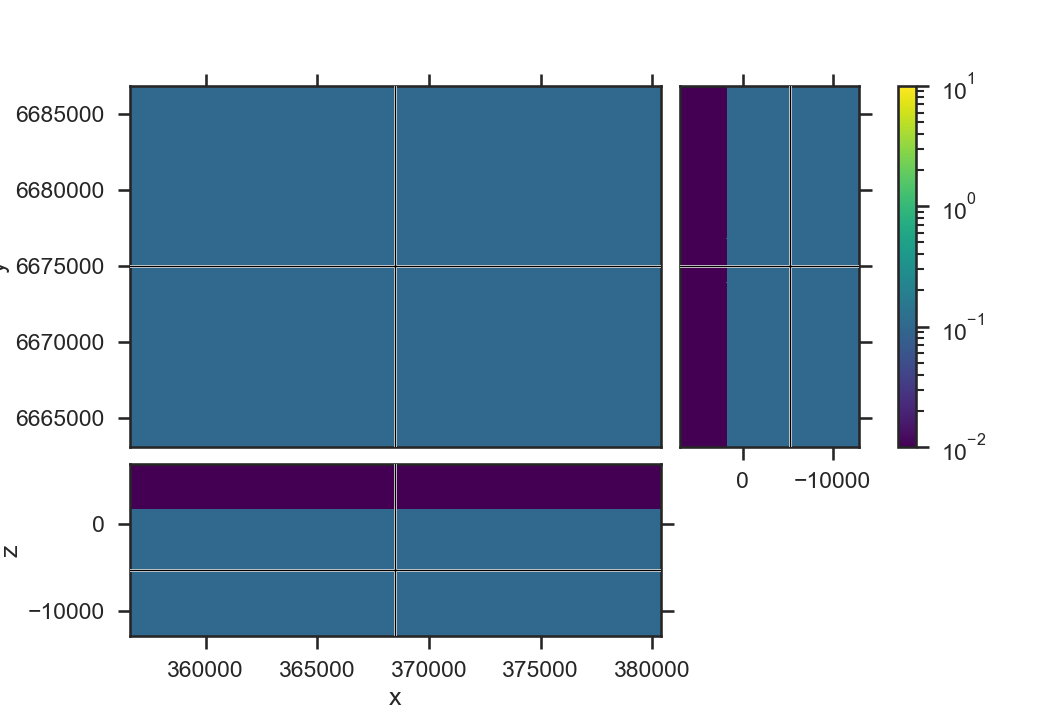

In [28]:
clim = [0.01, 10]
grid.plot_3d_slicer(cond, clim=clim, pcolorOpts={'cmap': 'viridis', 'norm': LogNorm()})

In [22]:
dataset = grid.toVTK({'cond': np.log10(cond)})

# Create the rendering scene and add a grid axes
p = vista.Plotter(notebook=True)
p.show_grid(location='outer')

dparams = {'rng': np.log10(clim), 'cmap': 'viridis', 'show_edges': False}
# Add spatially referenced data to the scene

p.add_mesh(dataset.slice('x'), name='x-slice', **dparams)
p.add_mesh(dataset.slice('y'), name='y-slice', **dparams)
p.add_mesh(dataset.slice('z'), name='z-slice', **dparams)


# Show the scene!
p.show(use_panel=True)

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

## Calculate the conductivities

In [33]:
# Setup the the survey object
# Receiver locations
rx_x, rx_y = np.meshgrid(
    np.arange(np.mean(xminmax)-600, np.mean(xminmax)+601, 100),
    np.arange(np.mean(yminmax)-600, np.mean(yminmax)+601, 100))
rx_loc = np.hstack((simpeg.Utils.mkvc(rx_x, 2), simpeg.Utils.mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1))))

# Make a receiver list
rxList = []
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    rxList.append(NSEM.Rx.Point_impedance3D(rx_loc, rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_impedance3D(rx_loc, rx_orientation, 'imag'))
for rx_orientation in ['zx', 'zy']:
    rxList.append(NSEM.Rx.Point_tipper3D(rx_loc, rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_tipper3D(rx_loc, rx_orientation, 'imag'))

# Source list
srcList = [
    NSEM.Src.Planewave_xy_1Dprimary(rxList, freq)
    for freq in np.logspace(4, -2, 13)
]
# Survey MT
survey = NSEM.Survey(srcList)

# Setup the problem object
problem = NSEM.Problem3D_ePrimSec(grid, sigma=cond, sigmaPrimary=condBG)

problem.pair(survey)
problem.Solver = Solver

# Calculate the data
fields = problem.fields()
dataVec = survey.eval(fields)

# Add uncertainty to the data - 10% standard
# devation and 0 floor
dataVec.standard_deviation.fromvec(
    np.ones_like(simpeg.mkvc(dataVec)) * 0.1
)
dataVec.floor.fromvec(
    np.zeros_like(simpeg.mkvc(dataVec))
)

<IPython.core.display.Javascript object>


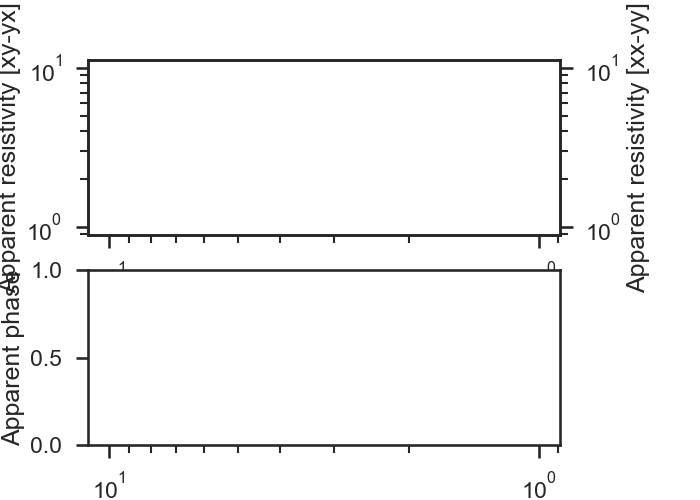

ValueError: need at least one array to concatenate

In [34]:
#collect_obj, line_obj = grid.plotSlice(np.log10(cond), grid=True, normal='X')
#color_bar = plt.colorbar(collect_obj)

# Plot the data
# On and off diagonal (on left and right axis, respectively)
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
plt.subplots_adjust(right=0.8)
[(ax.invert_xaxis(), ax.set_xscale('log')) for ax in axes]
ax_r, ax_p = axes
ax_r.set_yscale('log')
ax_r.set_ylabel('Apparent resistivity [xy-yx]')
ax_r_on = ax_r.twinx()
ax_r_on.set_yscale('log')
ax_r_on.set_ylabel('Apparent resistivity [xx-yy]')
ax_p.set_ylabel('Apparent phase')
ax_p.set_xlabel('Frequency [Hz]')

# Start plotting
ax_r = dataVec.plot_app_res(
    np.array([-200, 0]),
    components=['xy', 'yx'], ax=ax_r, errorbars=True)
ax_r_on = dataVec.plot_app_res(
    np.array([-200, 0]),
    components=['xx', 'yy'], ax=ax_r_on, errorbars=True)
ax_p = dataVec.plot_app_phs(
    np.array([-200, 0]),
    components=['xx', 'xy', 'yx', 'yy'], ax=ax_p, errorbars=True)
ax_p.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [31]:
simpeg.versions('HTML', [vista, panel, discretize])